### This notebook only includes models that performed well on the data. These selected models will be utilized for the web app

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau

2024-04-14 10:56:21.780973: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 10:56:21.781118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 10:56:21.960494: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data=pd.read_csv("/kaggle/input/dataset-news/1646977175-5e748a2d5fc288e9f69c5f86.csv")

In [3]:
data.head(5)

,Unnamed: 0,sentence,label
0,0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,sentence
1,1,"Born and raised in Houston, Texas, she perform...",sentence
2,2,"Managed by her father, Mathew Knowles, the gro...",sentence
3,3,Their hiatus saw the release of Beyoncé's debu...,sentence
4,4,Following the disbandment of Destiny's Child i...,sentence


In [4]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

##### Setting up environment for Lemmatizatiob

In [5]:
!sudo mkdir /root/nltk_data

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [6]:
!cp /usr/share/nltk_data/corpora/wordnet.zip /root/nltk_data/wordnet.zip && unzip /usr/share/nltk_data/corpora/wordnet.zip -d /root/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /root/nltk_data/corpora/wordnet/
  inflating: /root/nltk_data/corpora/wordnet/lexnames  
  inflating: /root/nltk_data/corpora/wordnet/data.verb  
  inflating: /root/nltk_data/corpora/wordnet/index.adv  
  inflating: /root/nltk_data/corpora/wordnet/adv.exc  
  inflating: /root/nltk_data/corpora/wordnet/index.verb  
  inflating: /root/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /root/nltk_data/corpora/wordnet/data.adj  
  inflating: /root/nltk_data/corpora/wordnet/index.adj  
  inflating: /root/nltk_data/corpora/wordnet/LICENSE  
  inflating: /root/nltk_data/corpora/wordnet/citation.bib  
  inflating: /root/nltk_data/corpora/wordnet/noun.exc  
  inflating: /root/nltk_data/corpora/wordnet/verb.exc  
  inflating: /root/nltk_data/corpora/wordnet/README  
  inflating: /root/nltk_data/corpora/wordnet/index.sense  
  inflating: /root/nltk_data/corpora/wordnet/data.noun  
  inflating: /root/nltk_data/corpora/wordnet/data.a

#### Preprocessing

In [7]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)

data['processed_sentence'] = data['sentence'].apply(preprocess_text)
data.drop(columns=["sentence","Unnamed: 0"], inplace=True)

In [8]:
data.isnull().sum().sum()

0

#### There is no missing values in the dataframe

In [9]:
data.head(2)

,label,processed_sentence
0,sentence,beyonc giselle knowlescarter bijnse beeyonsay ...
1,sentence,born raised houston texas performed various si...


##### Onehot encoding

In [10]:
label_map = {'question': 1, 'sentence': 0}
data['label'] = data['label'].map(label_map)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235110 entries, 0 to 235109
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   label               235110 non-null  int64 
 1   processed_sentence  235110 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [12]:
data.head(2)

,label,processed_sentence
0,0,beyonc giselle knowlescarter bijnse beeyonsay ...
1,0,born raised houston texas performed various si...


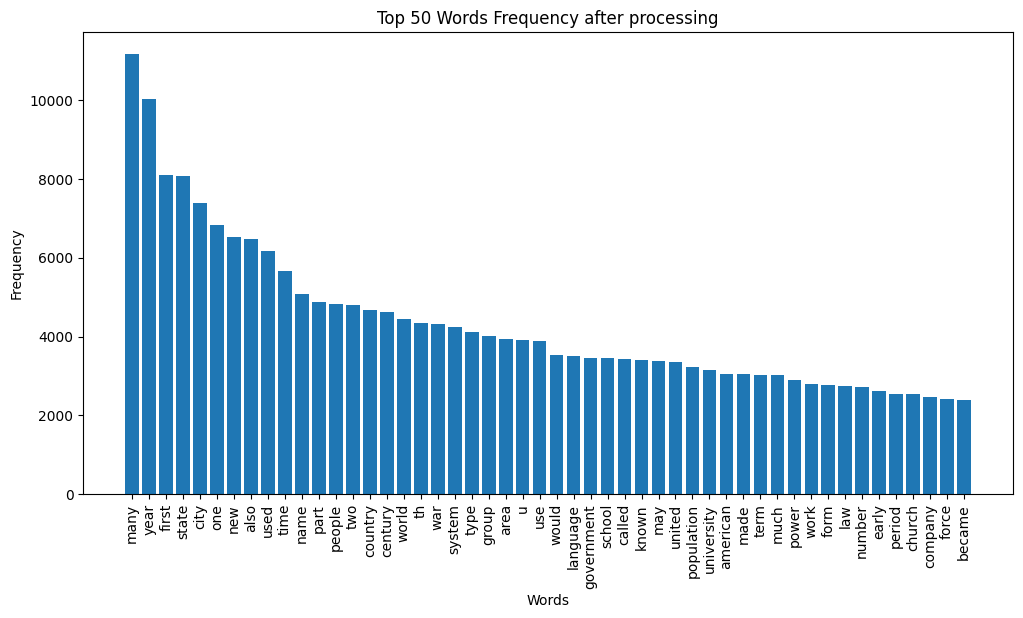

In [13]:
all_words = ' '.join(data['processed_sentence']).split()
word_freq = Counter(all_words)

top_50_words = word_freq.most_common(50)

words = [word[0] for word in top_50_words]
frequencies = [word[1] for word in top_50_words]

plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 50 Words Frequency after processing')
plt.xticks(rotation=90)
plt.show()

#### Target variable distribution

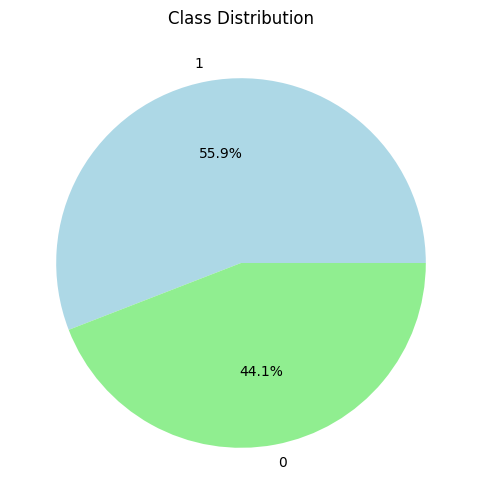

In [14]:
nlp = spacy.load("en_core_web_sm")
plt.figure(figsize=(6, 6))
data['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightgreen'])
plt.title('Class Distribution')
plt.ylabel('')
plt.show()

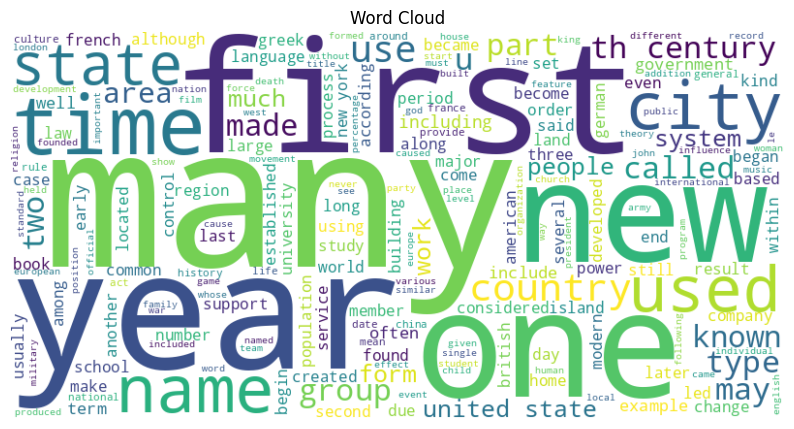

In [15]:
text = ' '.join(data['processed_sentence'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud')
plt.axis('off')
plt.show()

In [16]:
data["processed_sentence"][100]

'album formally introduces beyoncs alter ego sasha fierce conceived making single crazy love selling copy first week debuting atop billboard giving beyonc third consecutive numberone album u'

#### Vectorization using CountVectorizer


In [17]:
X = data['processed_sentence']
y = data['label']

count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(X)

**Corpus - Document - Word : Topic Generation**

In LDA, the modelling process revolves around three things: the text corpus, its collection of documents, D and the words W in the documents. Therefore the algorithm attempts to uncover K topics from this corpus via the following way (illustrated by the diagram)

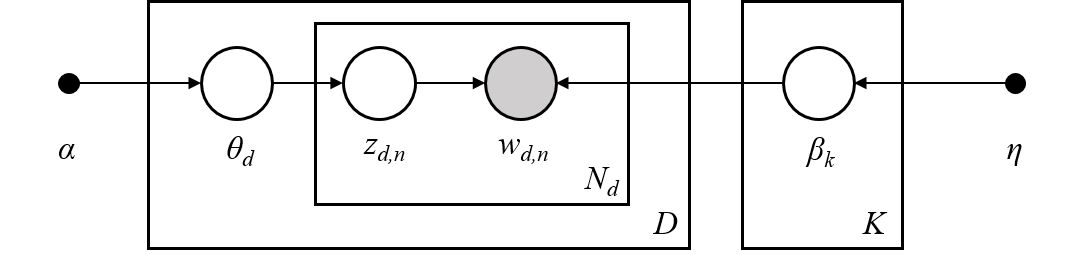

Model each topic, $\kappa$ via a Dirichlet prior distribution given by $\beta_{k}$:

Model each document d by another Dirichlet distribution parameterized by $\alpha$:

Subsequently for document d, we generate a topic via a multinomial distribution which we then backtrack and use to generate the correspondings words related to that topic via another multinomial distribution:


*(Image source: http://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation)*

The LDA algorithm first models documents via a mixture model of topics. From these topics, words are then assigned weights based on the probability distribution of these topics. It is this probabilistic assignment over words that allow a user of LDA to say how likely a particular word falls into a topic. Subsequently from the collection of words assigned to a particular topic, are we thus able to gain an insight as to what that topic may actually represent from a lexical point of view.

From a standard LDA model, there are really a few key parameters that we have to keep in mind and consider programmatically tuning before we invoke the model:
1. n_components: The number of topics that you specify to the model
2. $\alpha$ parameter: This is the dirichlet parameter that can be linked to the document topic prior 
3. $\beta$ parameter: This is the dirichlet parameter linked to the topic word prior

To invoke the  algorithm, we simply create an LDA instance through the Sklearn's *LatentDirichletAllocation* function. The various parameters would ideally have been obtained through some sort of validation scheme. In this instance, the optimal value of n_components (or topic number) was found by conducting a KMeans + Latent Semantic Analysis Scheme (as shown in this paper here) whereby the number of Kmeans clusters and number of LSA dimensions were iterated through and the best silhouette mean score.

##### We are using LDA with several parameters to reduce the running time and computational resource usage

In [18]:
lda_model = LatentDirichletAllocation(n_components=11, max_iter=5,
                                random_state = 42)
X_lda = lda_model.fit_transform(X_count)

X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((188088, 11), (47022, 11), (188088,), (47022,))

## LSTM With callback

LSTM expect a 3D data so we reshpe our data with a timestamp dimension to overcome the problem

In [20]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

I have used a lr callback to improve the performance

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 51s 31ms/step - accuracy: 0.5639 - loss: 0.6792 - val_accuracy: 0.5996 - val_loss: 0.6327 - learning_rate: 0.0050
Epoch 2/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.5924 - loss: 0.6378 - val_accuracy: 0.6055 - val_loss: 0.6278 - learning_rate: 0.0050
Epoch 3/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 45s 31ms/step - accuracy: 0.6010 - loss: 0.6313 - val_accuracy: 0.6141 - val_loss: 0.6282 - learning_rate: 0.0050
Epoch 4/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.6088 - loss: 0.6288 - val_accuracy: 0.6225 - val_loss: 0.6284 - learning_rate: 0.0050
Epoch 5/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 83s 32ms/step - accuracy: 0.6158 - loss: 0.6302 - val_accuracy: 0.6212 - val_loss: 0.6258 - learning_rate: 0.0050
Epoch 6/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 46s 31ms/step - accuracy: 0.6526 - loss: 0.5914 - val_accuracy: 0.8420 - val_loss: 0.3810 - learning_rate: 0.0050
Epoch 7/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - accura

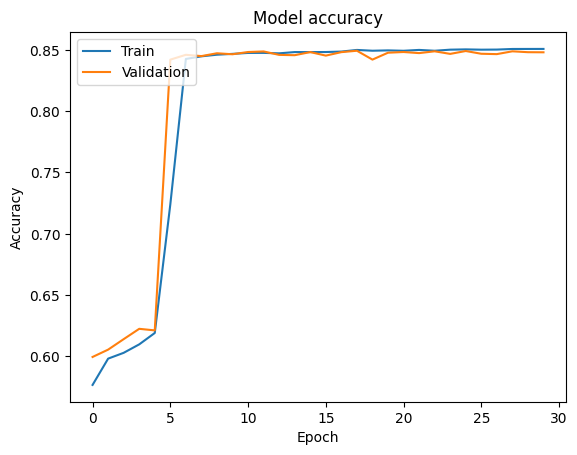

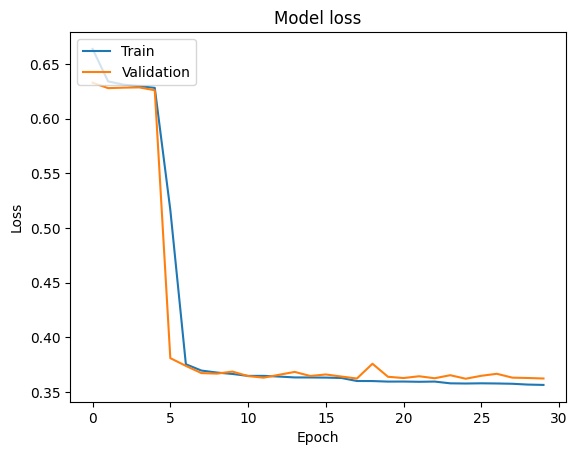

In [21]:
lr=0.005
# ReduceLROnPlateau callback
rd_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  
    factor=0.5, 
    patience=5, 
    verbose=1, 
    mode='auto', 
    min_delta=0.0001
)

# Our LSTM model
model_lstm = Sequential([
    LSTM(64, return_sequences=True, dropout=0.0, recurrent_dropout=0.0, input_shape=(X_train_reshaped.shape[1], 1)),
    LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

# compiling and training
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
history = model_lstm.fit(X_train_reshaped, y_train, epochs=30, batch_size=128, validation_data=(X_test_reshaped, y_test), callbacks=[rd_lr])

# Evaluate the model
y_pred_prob = model_lstm.predict(X_test_reshaped)
auc_score = roc_auc_score(y_test, y_pred_prob)
print("AUC Score:", auc_score)

loss, _ = model_lstm.evaluate(X_test_reshaped, y_test)
print("Validation Loss:", loss)

# Plot training curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


1470/1470 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step


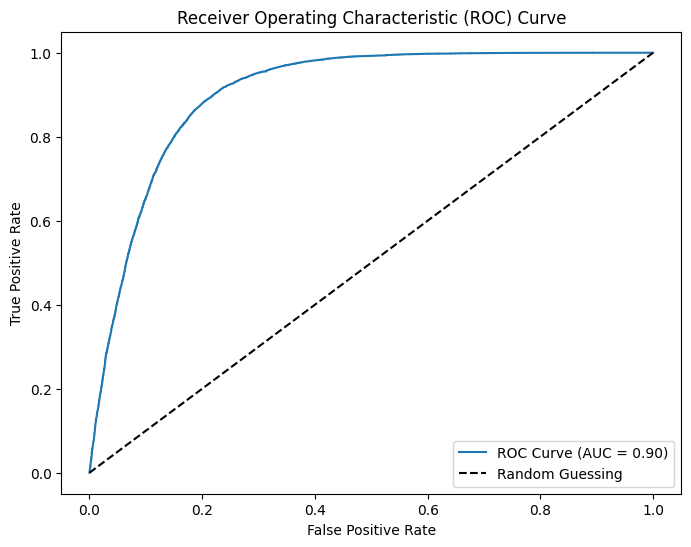

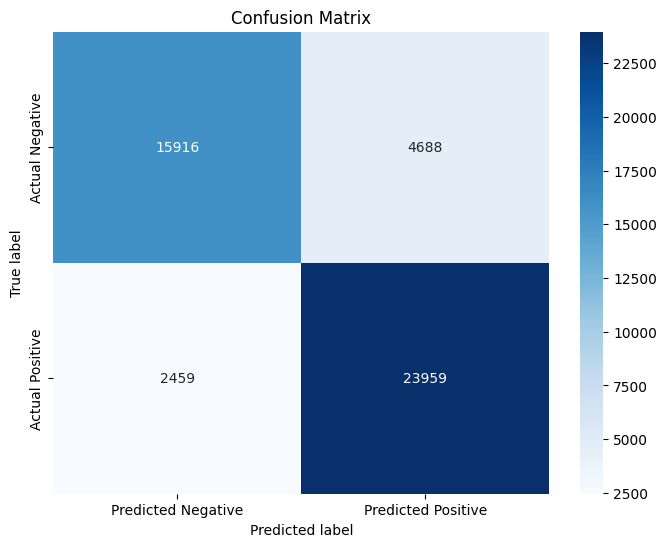

In [22]:
# For ROC
y_pred_prob = model_lstm.predict(X_test_reshaped)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# For confusion matrix
y_pred = (y_pred_prob > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

I would like to create a feedforward neural network to compare performance with an LSTM

####  NN based classification model (With callback)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1470/1470 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6701 - loss: 0.5804 - val_accuracy: 0.8258 - val_loss: 0.4075 - learning_rate: 0.0050
Epoch 2/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8237 - loss: 0.4125 - val_accuracy: 0.8326 - val_loss: 0.3938 - learning_rate: 0.0050
Epoch 3/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8294 - loss: 0.4018 - val_accuracy: 0.8308 - val_loss: 0.4013 - learning_rate: 0.0050
Epoch 4/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8335 - loss: 0.3957 - val_accuracy: 0.8313 - val_loss: 0.4052 - learning_rate: 0.0050
Epoch 5/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8372 - loss: 0.3897 - val_accuracy: 0.8377 - val_loss: 0.3930 - learning_rate: 0.0050
Epoch 6/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8379 - loss: 0.3904 - val_accuracy: 0.8337 - val_loss: 0.3968 - learning_rate: 0.0050
Epoch 7/30
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8360 - loss: 0.390

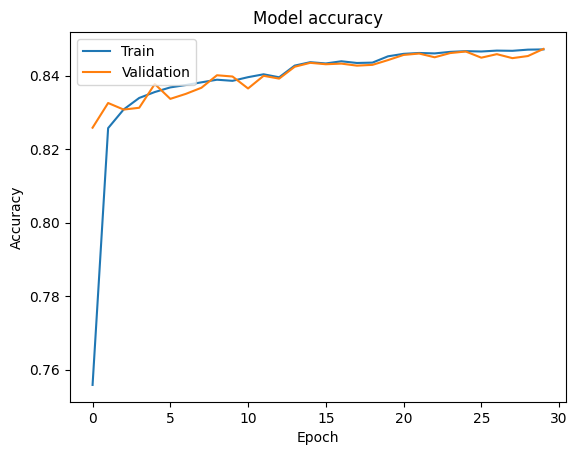

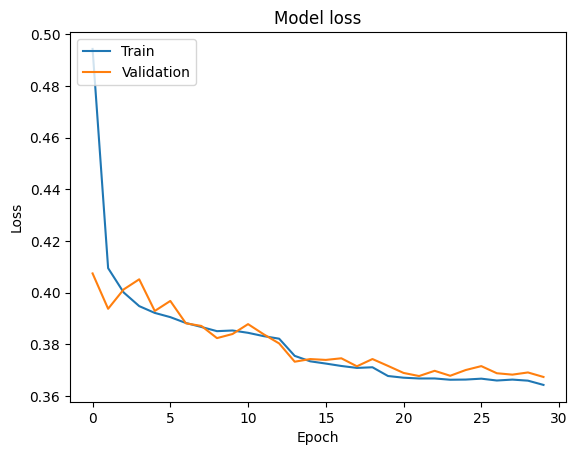

In [23]:
lr = 0.005
rd_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  
    factor=0.5, 
    patience=4, 
    verbose=1, 
    mode='auto', 
    min_delta=0.0001
)

model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),  
    Dropout(0.1),
    Dense(128, activation='relu'), 
    Dropout(0.1),
    Dense(128, activation='relu'),  
    Dropout(0.15),
    Dense(1, activation='sigmoid') 
])

model_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
history = model_nn.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_test, y_test), callbacks=[rd_lr])

y_pred_prob = model_nn.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred_prob)
print("AUC Score:", auc_score)

loss, _ = model_nn.evaluate(X_test, y_test)
print("Validation Loss:", loss)

#TRAINING CURVES
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


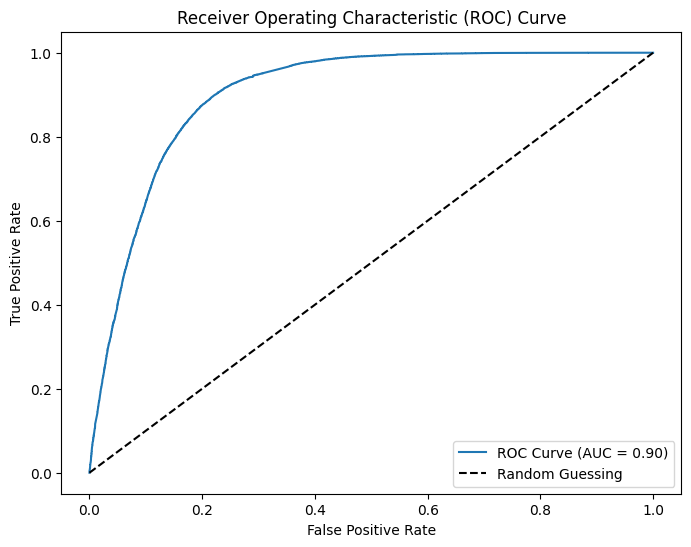

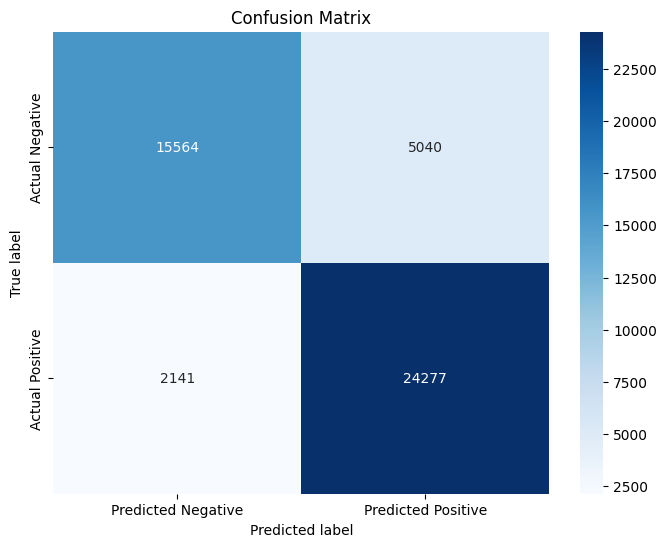

In [24]:
# For ROC
y_pred_prob = model_nn.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# For confusion matrix
y_pred = (y_pred_prob > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

## Saving the whole model for dockerizing

In [25]:
model_nn.save("nn_classifier.h5")

# TFIDF+Logistic regression model

### Cleaning the dataset for this model

In [26]:
data=pd.read_csv("/kaggle/input/dataset-news/1646977175-5e748a2d5fc288e9f69c5f86.csv")

In [27]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

data['clean_sentence'] = data['sentence'].apply(clean_text)

X_train, X_test, y_train, y_test = train_test_split(data['clean_sentence'], data['label'], test_size=0.2, random_state=42)

label_map = {'question': 1, 'sentence': 0}
y_train = y_train.map(label_map)
y_test = y_test.map(label_map)

### Vectorizing the data for training

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### Logistic regression model

In [29]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

#### ROC

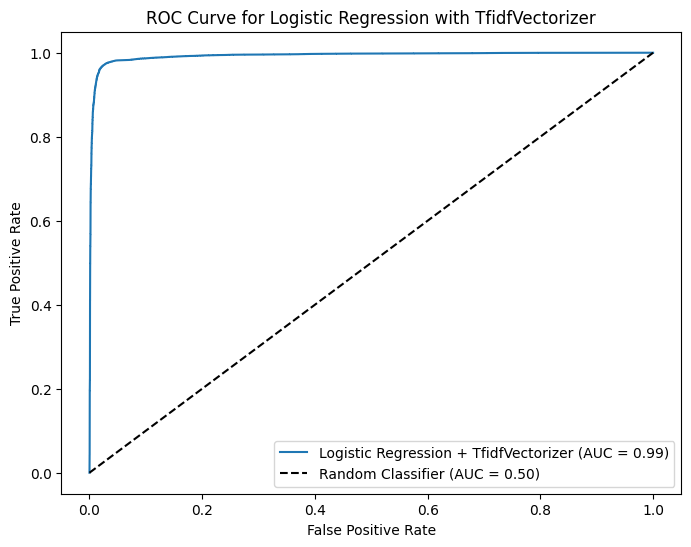

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression + TfidfVectorizer (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression with TfidfVectorizer')
plt.legend(loc='lower right')
plt.show()

#### Confusion matrix

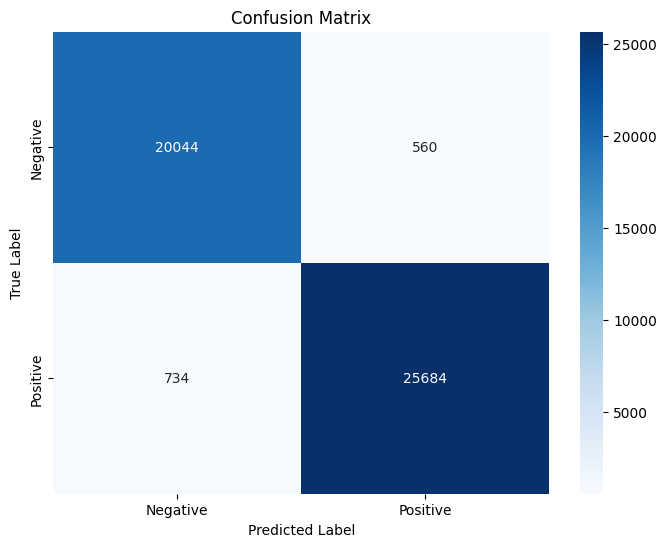

In [31]:
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Save the whole model including the vectorizer

In [32]:
import joblib
joblib.dump((vectorizer, model), 'model_with_vectorizer.pkl')

['model_with_vectorizer.pkl']